**Data Science Final Project at OESON by Yenne Yusuf Ezekiel**

*** Task: Sentiment Analyses***

In [54]:
#Importing required librarires

!pip install vaderSentiment
!pip install spacy
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
import seaborn as sns
from PIL import Image # converting images into arrays
import matplotlib.pyplot as plt # for visualizing the data
from wordcloud import WordCloud, STOPWORDS
import vaderSentiment
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk import  PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import spacy

from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

#metrics calculation
from sklearn import metrics
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

import warnings
warnings.simplefilter("ignore")


In [55]:
# Load the Corona data
df_corona=pd.read_csv('/Corona.csv', encoding='latin-1')
df_corona

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [56]:
# Check the second tweet
df_corona['OriginalTweet'][1]

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

**### Exploratory Data Analyses ###**

In [57]:
# Check the data information
df_corona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [58]:
# Check the columns of the record
df_corona.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [59]:
# Changing all the columns with the object data type to string
number_columns = ['Location', 'TweetAt', 'OriginalTweet','Sentiment']
for column in number_columns:
   df_corona[column] = df_corona[column].astype ("string")

df_corona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  string
 3   TweetAt        41157 non-null  string
 4   OriginalTweet  41157 non-null  string
 5   Sentiment      41157 non-null  string
dtypes: int64(2), string(4)
memory usage: 1.9 MB


In [60]:
# check data columns and shape
df_corona.columns
df_corona.shape

(41157, 6)

In [61]:
#check number of unique values in sentiment
print(df_corona['Sentiment'].nunique())

#check number of unique values in OriginalTweet
print(df_corona['OriginalTweet'].nunique())

5
41157


In [62]:
# Sentiment Category
df_corona['Sentiment']

0                   Neutral
1                  Positive
2                  Positive
3                  Positive
4        Extremely Negative
                ...        
41152               Neutral
41153    Extremely Negative
41154              Positive
41155               Neutral
41156              Negative
Name: Sentiment, Length: 41157, dtype: string

In [63]:
# Defining a function to clean the record
def clean_text(text):
  ps=PorterStemmer()
  text_cleaned="".join([x for x in text if x is not string.punctuation])#removing punctuation mark
  text_cleaned=text_cleaned.lower()  # Removing Mentions
  text_cleaned = re.sub(r"@\w+", "", text_cleaned)# Removing Hashtags
  text_cleaned = re.sub(r"#\w+", "", text_cleaned)# Removing Hashtags
  text_cleaned = re.sub(r"http\S+|www\S+|https\S+", "", text_cleaned, flags=re.MULTILINE)# Removing URLs
  text_cleaned = re.sub(r"\d+", "", text_cleaned) # Removing Numbers
  text_cleaned = re.sub("[^a-zA-Z'*]", ' ', text_cleaned) # Removing capital and uncommon character
  # Remove irregular spaces using regex
  text_cleaned = re.sub(r'\u00A0', '', text_cleaned)
  tokens=text_cleaned.split(" ")
  tokens=[token for token in tokens if token not in STOPWORDS]
  # Removing Spaces
  tokens = [token for token in tokens if token.strip()]
  text_cleaned=" ".join([ps.stem(token) for token in tokens])

  return text_cleaned

In [64]:
# Cleaning the original tweets
df_corona['cleaned_OriginalTweet']=df_corona['OriginalTweet'].apply(lambda x:clean_text(x))
df_corona.tail(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,cleaned_OriginalTweet
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,airlin pilot offer stock supermarket shelv loc...
41153,44952,89904,<NA>,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,respons complaint provid cite covid relat dela...
41154,44953,89905,<NA>,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive,know s get tough ration toilet paper martinsvi...
41155,44954,89906,<NA>,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,wrong smell hand sanit start turn
41156,44955,89907,i love you so much || he/him,14-04-2020,@TartiiCat Well new/used Rift S are going for ...,Negative,well new use rift s go amazon rn although norm...


In [65]:
# Removing the row containing the NaN values
df_corona = df_corona.dropna(axis=0) # Drop the rows containing NaN values, x=1 is for column
df_corona

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,cleaned_OriginalTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive,news region s first confirm covid case came su...
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive,cashier groceri store share insight prove cred...
...,...,...,...,...,...,...,...
41147,44946,89898,"Brooklyn, NY",14-04-2020,YÂall really shitting that much more at home?...,Negative,y realli shit much home
41149,44948,89900,"Toronto, Ontario",14-04-2020,Still shocked by the number of #Toronto superm...,Negative,still shock number supermarket employe work wi...
41150,44949,89901,OHIO,14-04-2020,I never that weÂd be in a situation &amp; wor...,Positive,never d situat amp world go supermarket pick p...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,airlin pilot offer stock supermarket shelv loc...


In [66]:
df_corona['Location']=df_corona['Location'].apply(lambda x:clean_text(x))
df_corona.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,cleaned_OriginalTweet
0,3799,48751,london,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,uk,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,3801,48753,vagabond,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...


**### Sentiment Analyses ###**

In [67]:
# Renaming the SentimentIntensityAnalyzer as analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser=SentimentIntensityAnalyzer()

In [68]:
# Define a function to apply the sentiment label
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score
# Define compound score that represents the overall sentiment
def compound_score(text):
    comp=sentiment_analyzer_scores(text)
    return comp['compound']

In [69]:
# Applying the function created on the cleaned data
df_corona['cleaned_OriginalTweet_Numb']=df_corona['cleaned_OriginalTweet'].apply(lambda x:compound_score(x))
df_corona['cleaned_OriginalTweet_Numb']

0        0.0000
1        0.1531
2        0.0000
5        0.8316
6        0.2960
          ...  
41147   -0.5574
41149   -0.3182
41150    0.3400
41152    0.0000
41156    0.4215
Name: cleaned_OriginalTweet_Numb, Length: 32567, dtype: float64

In [70]:
# Creating categories of the sentences based on the strength of the sentiments
def sentiment_category(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

In [71]:
# Apply the scores to all the sentiments and view the first 5 records
df_corona['cleaned_OriginalTweet_Numb_category']=df_corona['cleaned_OriginalTweet_Numb'].apply(lambda x :sentiment_category(x))
df_corona['cleaned_OriginalTweet_Numb_category'].head(5)

0     neutral
1    positive
2     neutral
5    positive
6    positive
Name: cleaned_OriginalTweet_Numb_category, dtype: object

In [72]:
## Check the unique recruitment sources for the company
df_corona['cleaned_OriginalTweet_Numb_category'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

<Figure size 800x500 with 0 Axes>

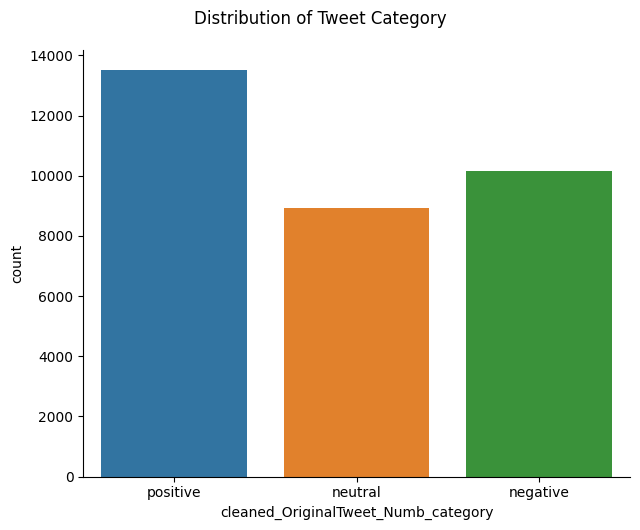

In [73]:
# Visualize the category target class
fig = plt.figure(figsize=(8,5))
g = sns.catplot(x="cleaned_OriginalTweet_Numb_category",kind='count',order=['positive', 'neutral', 'negative'], aspect=1.3, data=df_corona);
g.fig.suptitle("Distribution of Tweet Category",y=1.05);

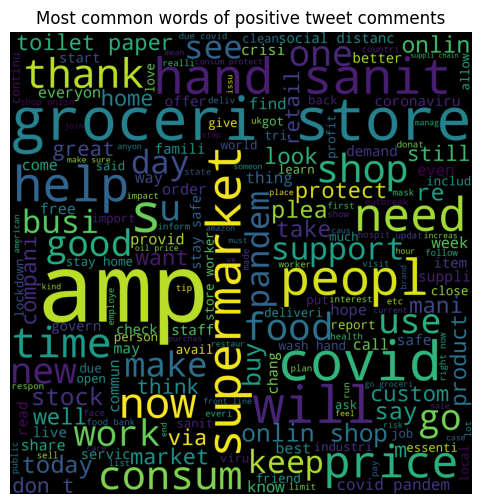

In [74]:
# Visualizing the most positive tweets
from wordcloud import WordCloud
wordcloud = WordCloud(height=2000, width=2000, background_color='black')
wordcloud = wordcloud.generate(' '.join(df_corona.loc[df_corona['cleaned_OriginalTweet_Numb_category']=='positive','cleaned_OriginalTweet'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words of positive tweet comments")
plt.axis('off')
plt.show()

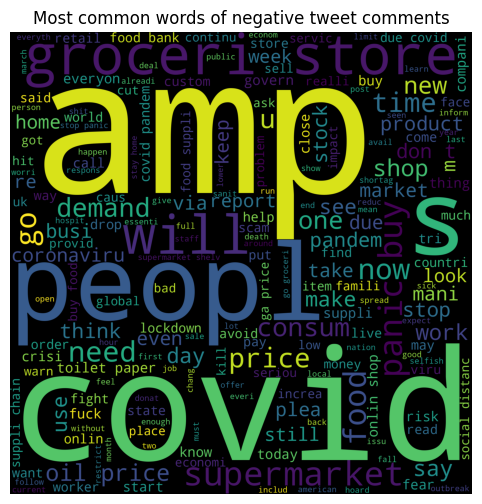

In [75]:
# Visualizing the most negative tweets
from wordcloud import WordCloud
wordcloud = WordCloud(height=2000, width=2000, background_color='black')
wordcloud = wordcloud.generate(' '.join(df_corona.loc[df_corona['cleaned_OriginalTweet_Numb_category']=='negative','cleaned_OriginalTweet'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words of negative tweet comments")
plt.axis('off')
plt.show()

In [76]:
# Define a function to count the number of times words occur in the tweet
from collections import Counter
def getMostCommon(reviews_list,topn=20):
    reviews=" ".join(reviews_list)
    tokenised_reviews=reviews.split(" ")
    freq_counter=Counter(tokenised_reviews)
    return freq_counter.most_common(topn)

In [77]:
# Getting the most common tweeted words to list
getMostCommon(df_corona['cleaned_OriginalTweet'].tolist(),topn=20)

[('covid', 8382),
 ('price', 7068),
 ('store', 6468),
 ('supermarket', 5638),
 ('food', 5496),
 ('groceri', 5090),
 ('amp', 4255),
 ('peopl', 4228),
 ('consum', 4216),
 ('s', 3923),
 ('shop', 3853),
 ('will', 3588),
 ('go', 3238),
 ('need', 2805),
 ('onlin', 2723),
 ('time', 2583),
 ('now', 2462),
 ('buy', 2453),
 ('t', 2355),
 ('work', 2311)]

In [78]:
# Convert the cleaned tweet to list
reviews_list=df_corona['cleaned_OriginalTweet'].tolist()

In [79]:
# Define a function to plot the number of times common word occurs for the first top 20
def plotMostCommonWords(reviews_list,topn=20,title="Common Review Words",color="blue",axis=None): #default number of words is given as 20
    top_words=getMostCommon(reviews_list,topn=topn)
    data=pd.DataFrame()
    data['words']=[val[0] for val in top_words]
    data['freq']=[val[1] for val in top_words]
    if axis!=None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title+" top "+str(topn))
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title+" top "+str(topn))

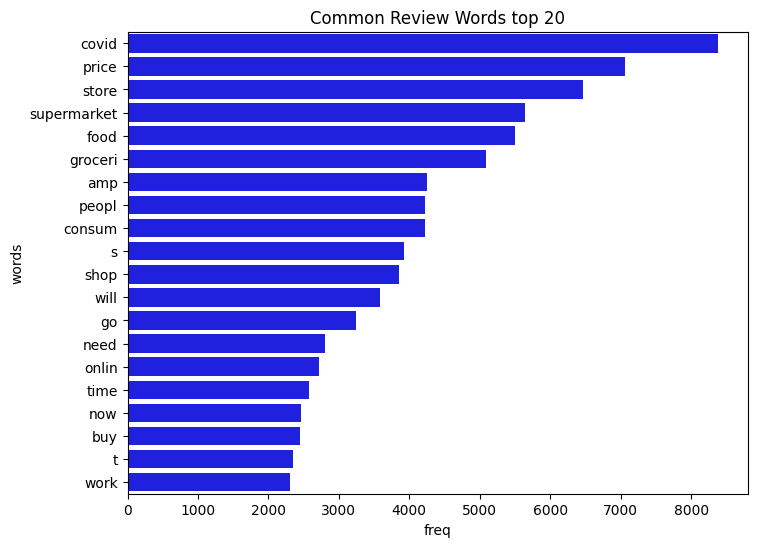

In [80]:
# Plot the number of count of times common word occurs for the first top 20
plotMostCommonWords(reviews_list)

In [81]:
# Count the number of times common word occurs for the first top 20 positive tweets
positive_reviews=df_corona.loc[df_corona['cleaned_OriginalTweet_Numb_category']=='positive','cleaned_OriginalTweet'].tolist()
top_20_positive_review_words=getMostCommon(positive_reviews,20)
top_20_positive_review_words

[('covid', 3378),
 ('store', 2807),
 ('price', 2507),
 ('supermarket', 2254),
 ('groceri', 2226),
 ('amp', 2161),
 ('food', 2083),
 ('hand', 1948),
 ('consum', 1879),
 ('help', 1835),
 ('shop', 1758),
 ('peopl', 1677),
 ('s', 1667),
 ('will', 1658),
 ('sanit', 1606),
 ('need', 1359),
 ('onlin', 1352),
 ('go', 1298),
 ('worker', 1277),
 ('time', 1275)]

In [82]:
# Count the number of times common word occurs for the first top 20 negative tweets
negative_reviews=df_corona.loc[df_corona['cleaned_OriginalTweet_Numb_category']=='negative','cleaned_OriginalTweet'].tolist()
top_20_negative_review_words=getMostCommon(positive_reviews,20)
top_20_negative_review_words

[('covid', 3378),
 ('store', 2807),
 ('price', 2507),
 ('supermarket', 2254),
 ('groceri', 2226),
 ('amp', 2161),
 ('food', 2083),
 ('hand', 1948),
 ('consum', 1879),
 ('help', 1835),
 ('shop', 1758),
 ('peopl', 1677),
 ('s', 1667),
 ('will', 1658),
 ('sanit', 1606),
 ('need', 1359),
 ('onlin', 1352),
 ('go', 1298),
 ('worker', 1277),
 ('time', 1275)]

In [83]:
# Define function to view the number of times common word occurs for the first top 20 negative and positive tweets
def plotMostCommonWords(reviews_list,topn=20,title="Common Review Words",color="blue",axis=None): #default number of words is given as 20
    top_words=getMostCommon(reviews_list,topn=topn)
    data=pd.DataFrame()
    data['words']=[val[0] for val in top_words]
    data['freq']=[val[1] for val in top_words]
    if axis!=None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title+" top "+str(topn))
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title+" top "+str(topn))

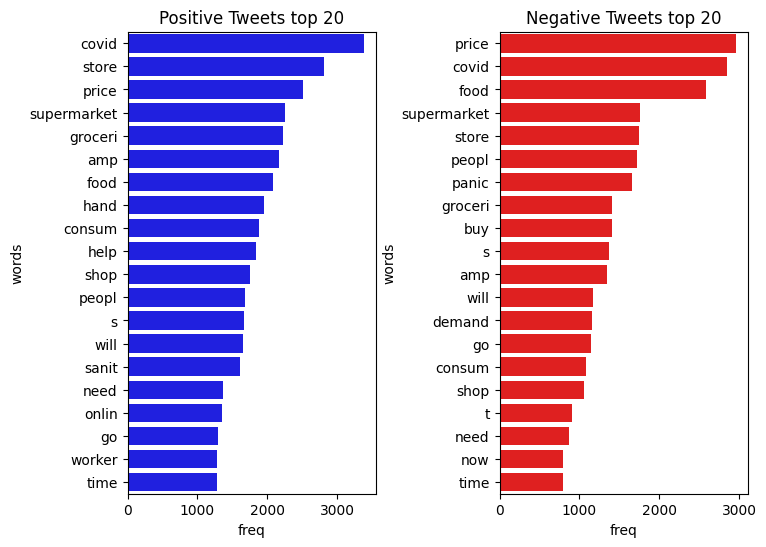

In [84]:
# Plot the number of positive and negatives on the map
from matplotlib import rcParams

rcParams['figure.figsize'] = 8,6 ## Sets the heigth and width of image


fig,ax=plt.subplots(1,2)
fig.subplots_adjust(wspace=0.5) #Adjusts the space between the two plots
plotMostCommonWords(positive_reviews,20,"Positive Tweets",axis=ax[0])

plotMostCommonWords(negative_reviews,20,"Negative Tweets",color="red",axis=ax[1])

**### Machine Learning (Text Classification Model) ###**

In [85]:
# Information about the dataframe after sentiment analyses
df_corona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32567 entries, 0 to 41156
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   UserName                             32567 non-null  int64  
 1   ScreenName                           32567 non-null  int64  
 2   Location                             32567 non-null  object 
 3   TweetAt                              32567 non-null  string 
 4   OriginalTweet                        32567 non-null  string 
 5   Sentiment                            32567 non-null  string 
 6   cleaned_OriginalTweet                32567 non-null  object 
 7   cleaned_OriginalTweet_Numb           32567 non-null  float64
 8   cleaned_OriginalTweet_Numb_category  32567 non-null  object 
dtypes: float64(1), int64(2), object(3), string(3)
memory usage: 2.5+ MB


In [86]:
# Creat new data frame considering the clean and category columns
df_corona_ML=pd.DataFrame(df_corona[['cleaned_OriginalTweet','cleaned_OriginalTweet_Numb_category']])
df_corona_ML

,cleaned_OriginalTweet,cleaned_OriginalTweet_Numb_category
0,,neutral
1,advic talk neighbour famili exchang phone numb...,positive
2,coronaviru australia woolworth give elderli di...,neutral
5,news region s first confirm covid case came su...,positive
6,cashier groceri store share insight prove cred...,positive
...,...,...
41147,y realli shit much home,negative
41149,still shock number supermarket employe work wi...,negative
41150,never d situat amp world go supermarket pick p...,positive
41152,airlin pilot offer stock supermarket shelv loc...,neutral


In [87]:
df_corona_ML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32567 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   cleaned_OriginalTweet                32567 non-null  object
 1   cleaned_OriginalTweet_Numb_category  32567 non-null  object
dtypes: object(2)
memory usage: 763.3+ KB


In [88]:
# Changing all the columns with the object data type to string
number_columns = ['cleaned_OriginalTweet', 'cleaned_OriginalTweet_Numb_category']
for column in number_columns:
   df_corona_ML[column] = df_corona_ML[column].astype ("string")

df_corona_ML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32567 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   cleaned_OriginalTweet                32567 non-null  string
 1   cleaned_OriginalTweet_Numb_category  32567 non-null  string
dtypes: string(2)
memory usage: 763.3 KB


In [89]:
# Creates TFIDF vectorizer and transforms the corpus i.e the x variable
vectorizer = TfidfVectorizer()
reviews_corpus = vectorizer.fit_transform(df_corona_ML.cleaned_OriginalTweet)
reviews_corpus.shape

(32567, 20238)

In [90]:
df_corona_ML['cleaned_OriginalTweet_Numb_category'].unique()

<StringArray>
['neutral', 'positive', 'negative']
Length: 3, dtype: string

In [91]:
# Define a function to assign numbers to the class

def sentiment_class(Target_class):
    if (Target_class == 'negative'):
        sentiment_class = 0
    elif(Target_class == 'neutral'):
        sentiment_class = 1
    elif(Target_class == 'positive'):
        sentiment_class=2
    return (sentiment_class)

In [92]:
df_corona_ML['cleaned_OriginalTweet_Numb_category1'] = df_corona_ML["cleaned_OriginalTweet_Numb_category"].apply(sentiment_class)
df_corona_ML

,cleaned_OriginalTweet,cleaned_OriginalTweet_Numb_category,cleaned_OriginalTweet_Numb_category1
0,,neutral,1
1,advic talk neighbour famili exchang phone numb...,positive,2
2,coronaviru australia woolworth give elderli di...,neutral,1
5,news region s first confirm covid case came su...,positive,2
6,cashier groceri store share insight prove cred...,positive,2
...,...,...,...
41147,y realli shit much home,negative,0
41149,still shock number supermarket employe work wi...,negative,0
41150,never d situat amp world go supermarket pick p...,positive,2
41152,airlin pilot offer stock supermarket shelv loc...,neutral,1


In [93]:
# Dependent feature i.e the y variable (target)
sentiment = df_corona_ML['cleaned_OriginalTweet_Numb_category']
sentiment.shape

(32567,)

In [94]:
#split the data in train and test
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(reviews_corpus,sentiment,test_size=0.40,random_state=42)
print('Train data shape ',X_train.shape,Y_train.shape)
print('Test data shape ',X_test.shape,Y_test.shape)

Train data shape  (19540, 20238) (19540,)
Test data shape  (13027, 20238) (13027,)


In [95]:
#fit the model and predict the output using the Naive Bayes model
clf = MultinomialNB().fit(X_train, Y_train) #fit the training data
pred = clf.predict(X_test) #predict the sentiment for test data
print("Accuracy: %s" % str(clf.score(X_test, Y_test))) #check accuracy
print("Confusion Matrix")
print(confusion_matrix(pred, Y_test)) #print confusion matrix

Accuracy: 0.6081215936132648
Confusion Matrix
[[2288  391  173]
 [  31  498   28]
 [1746 2736 5136]]


In [96]:
#fit the model and predict the output using Logistic Regression model
logistic_model = LogisticRegression()
# Fit the model on the training data
logistic_model.fit(X_train, Y_train)
# Predict the sentiment for the test data
pred = logistic_model.predict(X_test)
# Evaluate the accuracy
accuracy = logistic_model.score(X_test, Y_test)
print("Accuracy: %s" % str(accuracy))
# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(pred, Y_test))

Accuracy: 0.8706532586167192
Confusion Matrix:
[[3292  167  221]
 [ 442 3264  330]
 [ 331  194 4786]]


In [97]:
#fit the model and predict the output using LinearSVC
svm_model = LinearSVC()
# Fit the model on the training data
svm_model.fit(X_train, Y_train)
# Predict the labels for the test data
y_pred = svm_model.predict(X_test)
# Evaluate the accuracy
accuracy = svm_model.score(X_test, Y_test)
print("Accuracy: %s" % str(accuracy))
# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(pred, Y_test))


Accuracy: 0.9020495893145006
Confusion Matrix:
[[3292  167  221]
 [ 442 3264  330]
 [ 331  194 4786]]


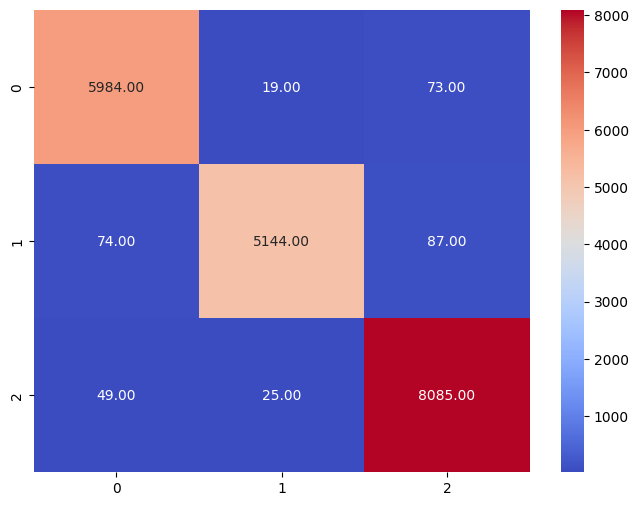

In [98]:
# Checking prediction based on confusion matrix for the training data
predictions = svm_model.predict(X_train)
data_confusion=confusion_matrix(Y_train, predictions)
# Create a heatmap for the confusion matrix
sns.heatmap(data_confusion, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=True, yticklabels=True)

# Display the heatmap
plt.show()

In [99]:
print(metrics.classification_report(Y_train, predictions, digits=3))

              precision    recall  f1-score   support

    negative      0.980     0.985     0.982      6076
     neutral      0.992     0.970     0.980      5305
    positive      0.981     0.991     0.986      8159

    accuracy                          0.983     19540
   macro avg      0.984     0.982     0.983     19540
weighted avg      0.983     0.983     0.983     19540



In [100]:
# Saving the model into a pickle file
import pickle

# the 'wb' means write to binary file
with open('my_best_regressor','wb') as my_file:
    pickle.dump(LinearSVC(), my_file)
print("best regressor successfully saved")

best regressor successfully saved
